In [1]:



from collections import defaultdict, Counter
from Bio import SeqIO

# Define file paths and k-mer length
readss = "reads.fasta"
transcripts = "chr11_transcriptome.fasta"
k = 30

def load_reads(readss):
    reads = []
    with open(readss, "r") as file:
        read_seq = ""
        for line in file:
            if line.startswith(">"):
                if read_seq:
                    read_seq = read_seq.replace('N', '')
                    if read_seq:
                        reads.append(read_seq)
                    read_seq = ""
            else:
                read_seq += line.strip()
        if read_seq:  # add the last sequence if the file does not end with ">"
            read_seq = read_seq.replace('N', '')
            if read_seq:
                reads.append(read_seq)
    return reads

def load_isoforms(transcripts):
    isoforms = {}
    with open(transcripts, "r") as file:
        isoform_id = ""
        isoform_seq = ""
        for line in file:
            if line.startswith(">"):
                if isoform_seq:
                    isoforms[isoform_id] = isoform_seq
                    isoform_seq = ""
                isoform_id = line[1:].strip()
            else:
                isoform_seq += line.strip()
        if isoform_seq:  # add the last sequence if the file does not end with ">"
            isoforms[isoform_id] = isoform_seq
    return isoforms



def build_kmer_map(isoforms, k):
    from itertools import islice

    def sliding_window(seq, k):
        it = iter(seq)
        result = tuple(islice(it, k))
        if len(result) == k:
            yield "".join(result)
        for elem in it:
            result = result[1:] + (elem,)
            yield "".join(result)
    
    kmer_map = defaultdict(set)
    for iso, seq in isoforms.items():
        for kmer in sliding_window(seq, k):
            kmer_map[kmer].add(iso)
    return kmer_map

def generate_equivalence_classes(read_seq, k, kmer_map):
    eq_classes = None
    for i in range(len(read_seq) - k + 1):
        kmer = read_seq[i:i + k]
        if kmer not in kmer_map:
            return None
        elif eq_classes is None:
            eq_classes = kmer_map[kmer].copy()
        else:
            eq_classes &= kmer_map[kmer]
        if not eq_classes:
            return None
    return eq_classes

def get_reverse_complement(seq):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return ''.join(complement.get(base, 'N') for base in reversed(seq))

def process_reads(reads, k, kmer_map):
    reads_eq_classes = []
    unmapped_count = 0
    for read_seq in reads:
        read_seq_rc = get_reverse_complement(read_seq)
        eq_class = generate_equivalence_classes(read_seq, k, kmer_map)
        eq_class_rev = generate_equivalence_classes(read_seq_rc, k, kmer_map)
        if eq_class is None and eq_class_rev is None:
            reads_eq_classes.append(None)
            unmapped_count += 1
        elif eq_class is None:
            reads_eq_classes.append(eq_class_rev)
        elif eq_class_rev is None:
            reads_eq_classes.append(eq_class)
        else:
            reads_eq_classes.append(eq_class | eq_class_rev)
    print(f"Number of reads that didn't map to anything: {unmapped_count}")
    return reads_eq_classes

def count_equivalence_classes(reads_eq_classes):
    eq_class_tuples = [
        tuple(sorted(read_eq)) if read_eq is not None else ('NA',)
        for read_eq in reads_eq_classes
    ]
    eq_class_labels_dict = Counter(eq_class_tuples)

    print(f"Number of unique equivalence classes: {len(eq_class_labels_dict)}")

    return eq_class_labels_dict

def write_output(eq_class_labels_dict, output_file="output.tsv"):
    sorted_labels = sorted(eq_class_labels_dict.items(), key=lambda kv: (len(kv[0]), kv[0]))
    with open(output_file, "w") as f:
        f.write("counts\tnumber of items in equivalence class\tisoforms in equivalence class\n")
        for classes, counts in sorted_labels:
            label = 'NA' if classes == ('NA',) else ','.join(classes)
            f.write(f"{counts}\t{len(classes)}\t{label}\n")
            print(f"Equivalence class: {label}, Counts: {counts}, Number of items: {len(classes)}")


In [2]:


reads = load_reads(readss)
isoforms = load_isoforms(transcripts)
kmer_map = build_kmer_map(isoforms, k)
reads_eq_classes = process_reads(reads, k, kmer_map)
eq_class_labels_dict = count_equivalence_classes(reads_eq_classes)
write_output(eq_class_labels_dict)




Number of reads that didn't map to anything: 231385
Number of unique equivalence classes: 10273
Equivalence class: ENST00000003302, Counts: 13, Number of items: 1
Equivalence class: ENST00000005286, Counts: 1, Number of items: 1
Equivalence class: ENST00000020926, Counts: 3, Number of items: 1
Equivalence class: ENST00000039989, Counts: 217, Number of items: 1
Equivalence class: ENST00000054950, Counts: 901, Number of items: 1
Equivalence class: ENST00000064778, Counts: 2, Number of items: 1
Equivalence class: ENST00000064780, Counts: 82, Number of items: 1
Equivalence class: ENST00000164133, Counts: 275, Number of items: 1
Equivalence class: ENST00000176195, Counts: 5, Number of items: 1
Equivalence class: ENST00000200135, Counts: 33, Number of items: 1
Equivalence class: ENST00000227155, Counts: 1986, Number of items: 1
Equivalence class: ENST00000227157, Counts: 16, Number of items: 1
Equivalence class: ENST00000227163, Counts: 5, Number of items: 1
Equivalence class: ENST0000022732

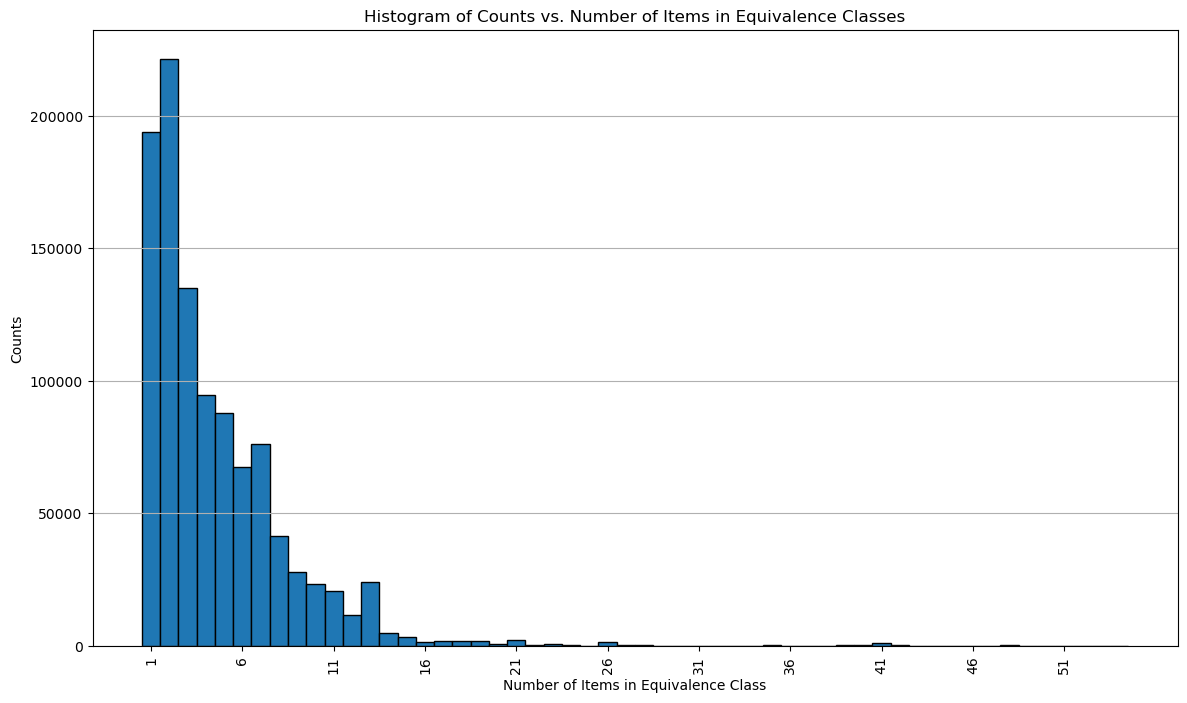

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting counts and number of items in equivalence classes for histogram
counts = [value for key, value in eq_class_labels_dict.items() if key != ('NA',)]
number_of_items = [len(key) for key in eq_class_labels_dict.keys() if key != ('NA',)]

# Create the histogram
plt.figure(figsize=(14, 8))

# Create bins
bins = np.arange(1, max(number_of_items) + 2) - 0.5

# Plot the histogram
plt.hist(number_of_items, weights=counts, bins=bins, edgecolor='black', align='mid')

# Set axis labels and title
plt.xlabel('Number of Items in Equivalence Class')
plt.ylabel('Counts')
plt.title('Histogram of Counts vs. Number of Items in Equivalence Classes')

# Adjust x-ticks
plt.xticks(np.arange(1, max(number_of_items) + 1, step=5), rotation=90)

# Add grid lines
plt.grid(axis='y')

# Show the plot
plt.show()


Number of reads that didn't map to anything: 231385
Number of unique equivalence classes: 10273
Mean number of items in equivalence classes: 5.04
Median number of items in equivalence classes: 3.00
Standard deviation of items in equivalence classes: 5.24


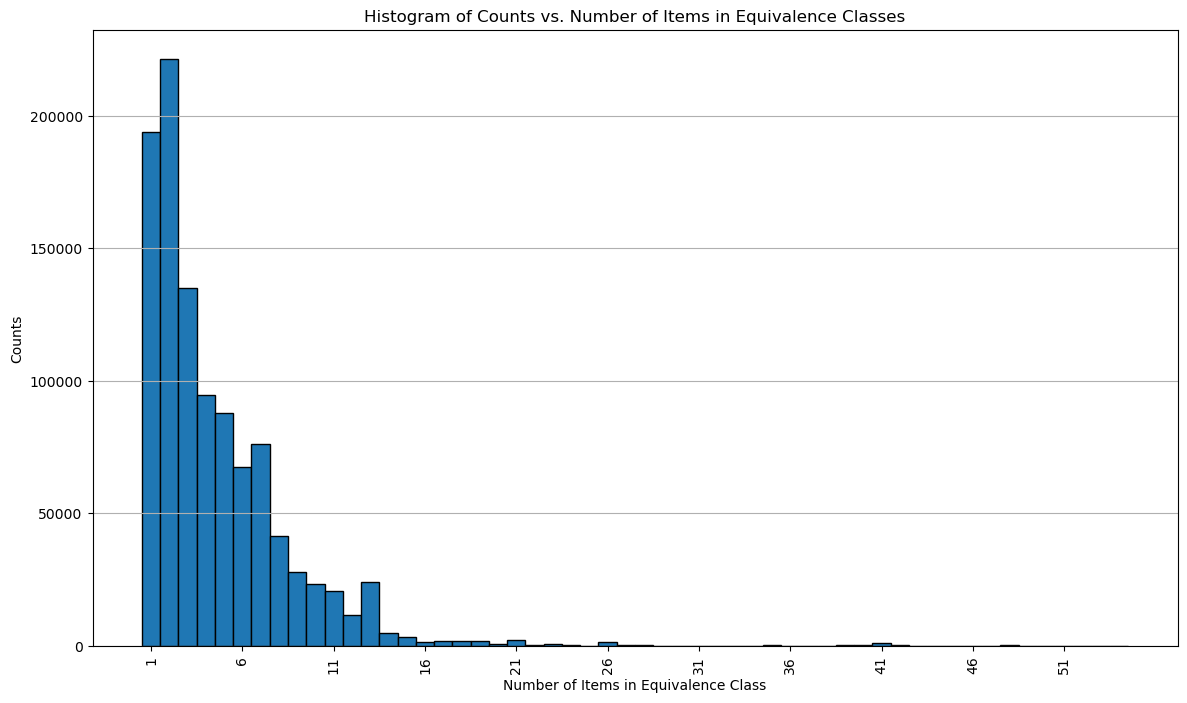

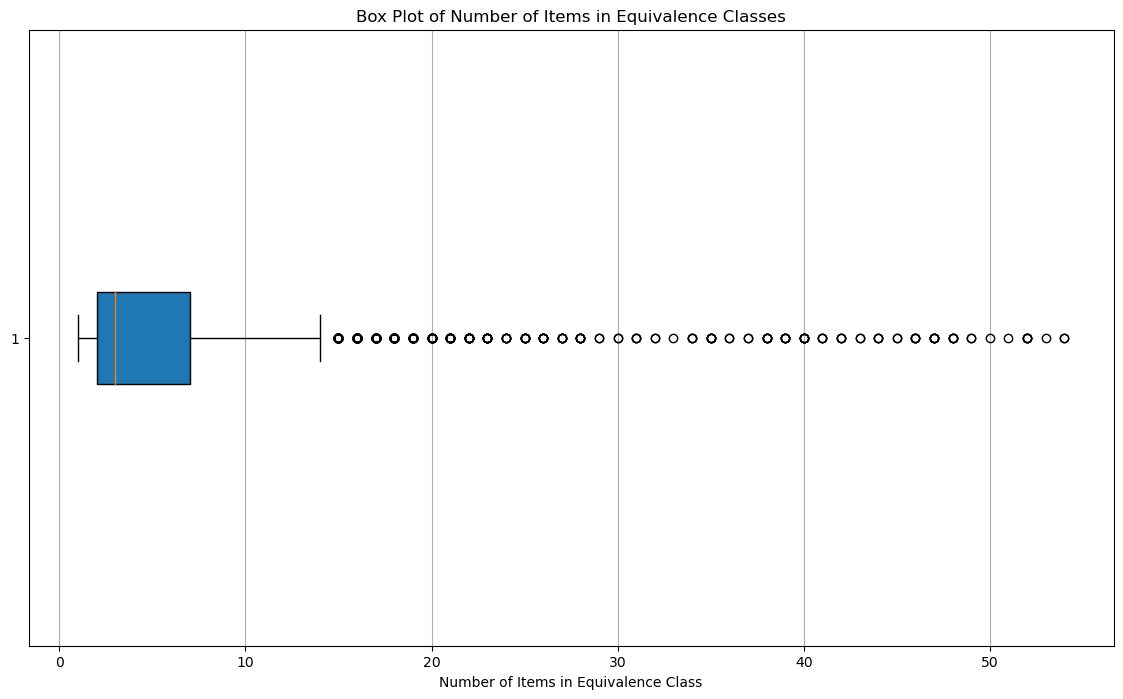

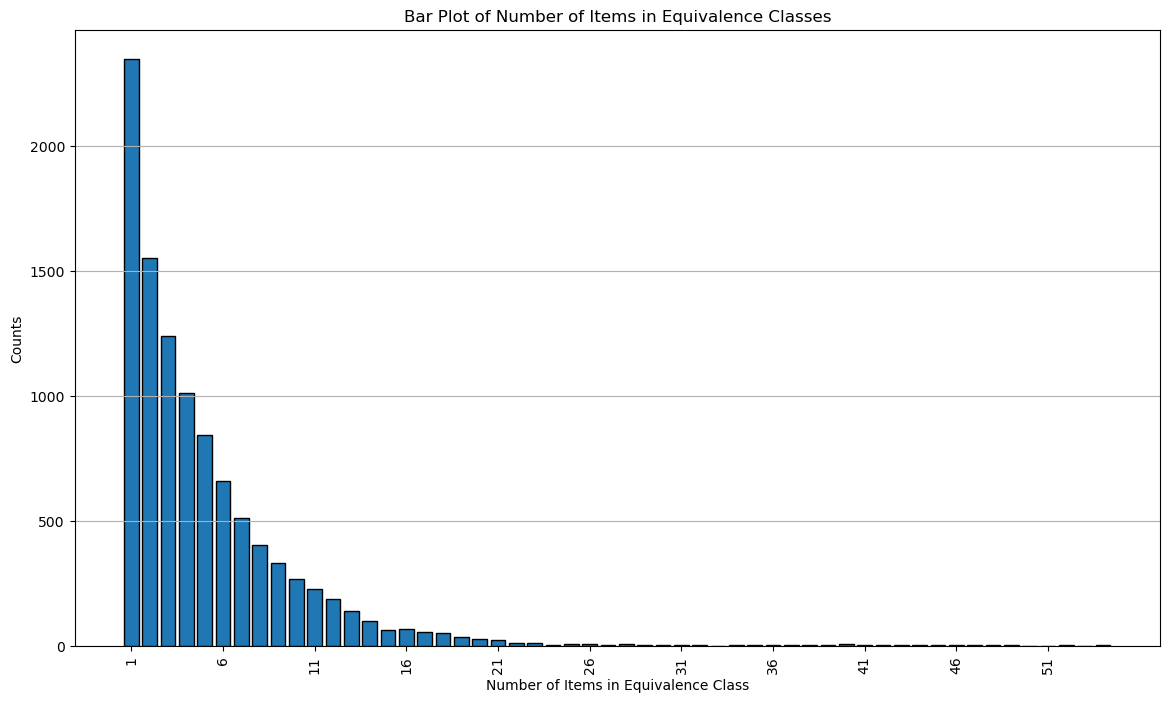

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
from Bio import SeqIO

# Define file paths and k-mer length
readss = "reads.fasta"
transcripts = "chr11_transcriptome.fasta"
k = 30

def load_reads(readss):
    reads = []
    with open(readss, "r") as file:
        read_seq = ""
        for line in file:
            if line.startswith(">"):
                if read_seq:
                    read_seq = read_seq.replace('N', '')
                    if read_seq:
                        reads.append(read_seq)
                    read_seq = ""
            else:
                read_seq += line.strip()
        if read_seq:  # add the last sequence if the file does not end with ">"
            read_seq = read_seq.replace('N', '')
            if read_seq:
                reads.append(read_seq)
    return reads

def load_isoforms(transcripts):
    isoforms = {}
    with open(transcripts, "r") as file:
        isoform_id = ""
        isoform_seq = ""
        for line in file:
            if line.startswith(">"):
                if isoform_seq:
                    isoforms[isoform_id] = isoform_seq
                    isoform_seq = ""
                isoform_id = line[1:].strip()
            else:
                isoform_seq += line.strip()
        if isoform_seq:  # add the last sequence if the file does not end with ">"
            isoforms[isoform_id] = isoform_seq
    return isoforms

def build_kmer_map(isoforms, k):
    from itertools import islice

    def sliding_window(seq, k):
        it = iter(seq)
        result = tuple(islice(it, k))
        if len(result) == k:
            yield "".join(result)
        for elem in it:
            result = result[1:] + (elem,)
            yield "".join(result)
    
    kmer_map = defaultdict(set)
    for iso, seq in isoforms.items():
        for kmer in sliding_window(seq, k):
            kmer_map[kmer].add(iso)
    return kmer_map

def generate_equivalence_classes(read_seq, k, kmer_map):
    eq_classes = None
    for i in range(len(read_seq) - k + 1):
        kmer = read_seq[i:i + k]
        if kmer not in kmer_map:
            return None
        elif eq_classes is None:
            eq_classes = kmer_map[kmer].copy()
        else:
            eq_classes &= kmer_map[kmer]
        if not eq_classes:
            return None
    return eq_classes

def get_reverse_complement(seq):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return ''.join(complement.get(base, 'N') for base in reversed(seq))

def process_reads(reads, k, kmer_map):
    reads_eq_classes = []
    unmapped_count = 0
    for read_seq in reads:
        read_seq_rc = get_reverse_complement(read_seq)
        eq_class = generate_equivalence_classes(read_seq, k, kmer_map)
        eq_class_rev = generate_equivalence_classes(read_seq_rc, k, kmer_map)
        if eq_class is None and eq_class_rev is None:
            reads_eq_classes.append(None)
            unmapped_count += 1
        elif eq_class is None:
            reads_eq_classes.append(eq_class_rev)
        elif eq_class_rev is None:
            reads_eq_classes.append(eq_class)
        else:
            reads_eq_classes.append(eq_class | eq_class_rev)
    print(f"Number of reads that didn't map to anything: {unmapped_count}")
    return reads_eq_classes

def count_equivalence_classes(reads_eq_classes):
    eq_class_tuples = [
        tuple(sorted(read_eq)) if read_eq is not None else ('NA',)
        for read_eq in reads_eq_classes
    ]
    eq_class_labels_dict = Counter(eq_class_tuples)

    print(f"Number of unique equivalence classes: {len(eq_class_labels_dict)}")

    return eq_class_labels_dict

def write_output(eq_class_labels_dict, output_file="output.tsv"):
    sorted_labels = sorted(eq_class_labels_dict.items(), key=lambda kv: (len(kv[0]), kv[0]))
    with open(output_file, "w") as f:
        f.write("counts\tnumber of items in equivalence class\tisoforms in equivalence class\n")
        for classes, counts in sorted_labels:
            label = 'NA' if classes == ('NA',) else ','.join(classes)
            f.write(f"{counts}\t{len(classes)}\t{label}\n")
            print(f"Equivalence class: {label}, Counts: {counts}, Number of items: {len(classes)}")

# Load data
reads = load_reads(readss)
isoforms = load_isoforms(transcripts)
kmer_map = build_kmer_map(isoforms, k)
reads_eq_classes = process_reads(reads, k, kmer_map)
eq_class_labels_dict = count_equivalence_classes(reads_eq_classes)

# Extracting counts and number of items in equivalence classes for histogram
counts = [value for key, value in eq_class_labels_dict.items() if key != ('NA',)]
number_of_items = [len(key) for key in eq_class_labels_dict.keys() if key != ('NA',)]

# Calculate additional statistics
mean_num_items = np.mean(number_of_items)
median_num_items = np.median(number_of_items)
std_num_items = np.std(number_of_items)

print(f"Mean number of items in equivalence classes: {mean_num_items:.2f}")
print(f"Median number of items in equivalence classes: {median_num_items:.2f}")
print(f"Standard deviation of items in equivalence classes: {std_num_items:.2f}")

# Plot the histogram
plt.figure(figsize=(14, 8))
bins = np.arange(1, max(number_of_items) + 2) - 0.5
plt.hist(number_of_items, weights=counts, bins=bins, edgecolor='black', align='mid')
plt.xlabel('Number of Items in Equivalence Class')
plt.ylabel('Occurences')
plt.title('Histogram of Occurences vs. Number of Items in Equivalence Classes')
plt.xticks(np.arange(1, max(number_of_items) + 1, step=5), rotation=90)
plt.grid(axis='y')
plt.show()

# Box plot
plt.figure(figsize=(14, 8))
plt.boxplot(number_of_items, vert=False, patch_artist=True)
plt.xlabel('Number of Items in Equivalence Class')
plt.title('Box Plot of Number of Items in Equivalence Classes')
plt.grid(axis='x')
plt.show()

# Bar plot
plt.figure(figsize=(14, 8))
unique_items, counts = zip(*Counter(number_of_items).items())
plt.bar(unique_items, counts, edgecolor='black')
plt.xlabel('Number of Items in Equivalence Class')
plt.ylabel('Occurences')
plt.title('Bar Plot of Number of Items in Equivalence Classes')
plt.xticks(np.arange(1, max(unique_items) + 1, step=5), rotation=90)
plt.grid(axis='y')
plt.show()
